# Batch RGB Latent Evolution: Multiple Colored Shapes with Cross-Image InfoNCE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/experiments/batch_rgb_latent_evolution.ipynb)

This notebook evolves a **batch of RGB latent images** simultaneously using the production BatchInfoNCELoss.

**Purpose**: Understand how batch InfoNCE loss encourages both within-image coherence and cross-image diversity.

**Workflow**:
1. Configure loss weights (including batch InfoNCE)
2. Start with batch of random RGB noise  
3. Watch them transform into diverse colored shapes frame-by-frame

**Key features**:
- Uses production `BatchInfoNCELoss` from phase1/
- Unified loss: within-image coherence + cross-image diversity
- Batch dimension `[B, 3, H, W]` for RGB latents
- Visualizations show all latents evolving over time

## Setup

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os

# Add phase1 directory to import production loss
sys.path.insert(0, '../phase1' if os.path.exists('../phase1') else 'phase1')

from batch_infonce_loss import BatchInfoNCELoss

print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print("✓ Imported BatchInfoNCELoss from production code")

PyTorch version: 2.2.2
Using device: cpu
✓ Imported BatchInfoNCELoss from production code


## Loss Functions

We use the production `BatchInfoNCELoss` which combines:
- **Within-image coherence**: Nearby patches in same image should be similar
- **Cross-image diversity**: Patches at corresponding locations in different images should differ

In [22]:
# Helper function for magnitude loss
def compute_magnitude_loss(latents, min_magnitude=0.3):
    """Prevents collapse to near-zero values"""
    magnitude = torch.mean(torch.abs(latents))
    return torch.relu(min_magnitude - magnitude)

print("✓ Magnitude loss helper defined")
print("✓ Using production BatchInfoNCELoss for main loss computation")

✓ Magnitude loss helper defined
✓ Using production BatchInfoNCELoss for main loss computation


## 1. Configure Loss Weights and Parameters

**Adjust these to control what the images look like!**

In [23]:
# ============================================================================
# LOSS WEIGHTS - EXPERIMENT WITH THESE!
# ============================================================================

weights = {
    # Magnitude: prevents collapse to near-zero values
    'magnitude': 5.0,
    
    # Batch InfoNCE: unified within-image coherence + cross-image diversity
    'batch_infonce': 1.0,
}

# ============================================================================
# BATCH INFONCE PARAMETERS
# ============================================================================

# Patch parameters
batch_infonce_patch_size = 3          # Patch size for InfoNCE (3x3x3 for RGB)
batch_infonce_num_samples = 25        # Number of anchor patches per image

# Within-image parameters (coherence)
batch_infonce_within_weight = 0.0     # Weight for within-image component
batch_infonce_temperature_within = 1.0  # Temperature for within-image similarity
batch_infonce_positive_radius = 5.0   # Max distance for positive pairs
batch_infonce_negative_radius = 15.0  # Min distance for negative pairs

# Cross-image parameters (diversity)
batch_infonce_across_weight = 1.0     # Weight for cross-image component
batch_infonce_temperature_across = 0.5  # Temperature for cross-image similarity (lower = stronger)
batch_infonce_cross_image_radius = 5.0  # Spatial tolerance for cross-image negatives (pixels)
batch_infonce_num_cross_images = 3    # Number of other images to sample (reduced for small batch)

# ============================================================================
# OPTIMIZATION SETTINGS
# ============================================================================

batch_size = 4               # Number of latents to evolve simultaneously
num_steps = 250              # Total optimization steps
snapshot_interval = 25       # Save visualization every N steps
learning_rate = 0.02         # Adam learning rate
image_size = 32              # Latent is 32x32 per channel
random_seed = 42             # For reproducibility (None = random)
min_magnitude = 0.3          # Minimum magnitude target

# ============================================================================

print("Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  RGB latent size per image: [3, {image_size}, {image_size}]")
print(f"  Total batch shape: [{batch_size}, 3, {image_size}, {image_size}]")
print(f"  Total steps: {num_steps}")
print(f"  Snapshots every {snapshot_interval} steps")
print(f"  Learning rate: {learning_rate}")

print(f"\nBatch InfoNCE parameters:")
print(f"  Patch size: {batch_infonce_patch_size}x{batch_infonce_patch_size}x3 (RGB)")
print(f"  Samples per image: {batch_infonce_num_samples}")
print(f"\n  Within-image (coherence):")
print(f"    Weight: {batch_infonce_within_weight}")
print(f"    Temperature: {batch_infonce_temperature_within}")
print(f"    Positive radius: {batch_infonce_positive_radius} pixels")
print(f"    Negative radius: {batch_infonce_negative_radius} pixels")
print(f"\n  Cross-image (diversity):")
print(f"    Weight: {batch_infonce_across_weight}")
print(f"    Temperature: {batch_infonce_temperature_across} (lower = stronger diversity)")
print(f"    Cross-image radius: {batch_infonce_cross_image_radius} pixels")
print(f"    Num cross images: {batch_infonce_num_cross_images}")

print(f"\nActive losses:")
for name, weight in weights.items():
    if weight > 0:
        print(f"  {name:30s}: {weight:.2f}")

Configuration:
  Batch size: 4
  RGB latent size per image: [3, 32, 32]
  Total batch shape: [4, 3, 32, 32]
  Total steps: 250
  Snapshots every 25 steps
  Learning rate: 0.02

Batch InfoNCE parameters:
  Patch size: 3x3x3 (RGB)
  Samples per image: 25

  Within-image (coherence):
    Weight: 0.0
    Temperature: 1.0
    Positive radius: 5.0 pixels
    Negative radius: 15.0 pixels

  Cross-image (diversity):
    Weight: 1.0
    Temperature: 0.5 (lower = stronger diversity)
    Cross-image radius: 5.0 pixels
    Num cross images: 3

Active losses:
  magnitude                     : 5.00
  batch_infonce                 : 1.00


## 2. Initialize Batch of RGB Latents

Start with Gaussian noise for each image

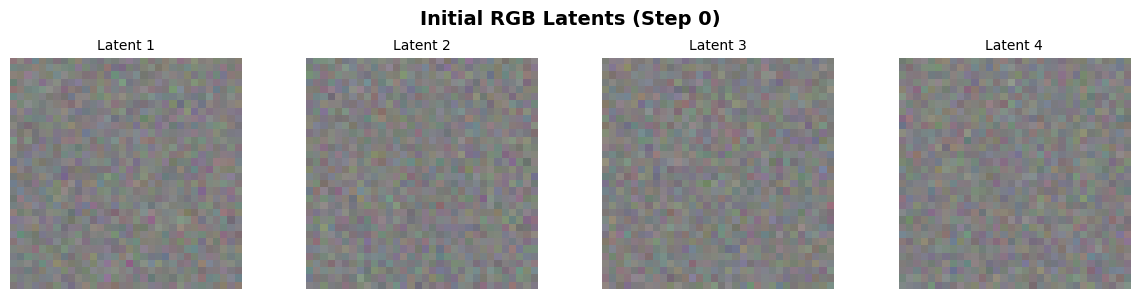

✓ Initialized latents: torch.Size([4, 3, 32, 32])
  Min value: -0.383
  Max value: 0.422
  Mean value: 0.001


In [24]:
# Set random seed if specified
if random_seed is not None:
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

# Initialize batch of RGB latents [B, 3, H, W]
latents = torch.randn(batch_size, 3, image_size, image_size) * 0.1
latents = latents.to(device)
latents.requires_grad_(True)

# Helper function to convert latent to displayable RGB
def latent_to_rgb(latent_chw):
    """Convert [3, H, W] tensor to [H, W, 3] numpy for display, normalized to [0, 1]"""
    rgb = latent_chw.detach().cpu().numpy()
    rgb = np.transpose(rgb, (1, 2, 0))  # [3, H, W] -> [H, W, 3]
    # Normalize from [-1.5, 1.5] to [0, 1]
    rgb = (rgb + 1.5) / 3.0
    rgb = np.clip(rgb, 0, 1)
    return rgb

# Visualize initial state
fig, axes = plt.subplots(1, batch_size, figsize=(3 * batch_size, 3))
if batch_size == 1:
    axes = [axes]

for i in range(batch_size):
    rgb = latent_to_rgb(latents[i])
    axes[i].imshow(rgb)
    axes[i].set_title(f'Latent {i+1}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Initial RGB Latents (Step 0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✓ Initialized latents: {latents.shape}")
print(f"  Min value: {latents.min().item():.3f}")
print(f"  Max value: {latents.max().item():.3f}")
print(f"  Mean value: {latents.mean().item():.3f}")

## 3. Run Optimization with Snapshots

Watch the latents evolve step by step!

In [25]:
# Initialize the loss function
batch_infonce_loss = BatchInfoNCELoss(
    within_weight=batch_infonce_within_weight,
    across_weight=batch_infonce_across_weight,
    patch_size=batch_infonce_patch_size,
    num_samples=batch_infonce_num_samples,
    temperature_within=batch_infonce_temperature_within,
    temperature_across=batch_infonce_temperature_across,
    positive_radius=batch_infonce_positive_radius,
    negative_radius=batch_infonce_negative_radius,
    cross_image_radius=batch_infonce_cross_image_radius,
    num_cross_images=batch_infonce_num_cross_images
)

print("✓ Batch InfoNCE loss initialized")

# Reset optimizer
optimizer = torch.optim.Adam([latents], lr=learning_rate)

# Storage for snapshots
snapshots = []  # List of [B, 3, H, W] numpy arrays
snapshot_steps = []
loss_history = []
loss_components_history = {name: [] for name in weights.keys()}

# Save initial state
snapshots.append(latents.detach().cpu().numpy().copy())
snapshot_steps.append(0)

print("Starting optimization...\n")

for step in range(num_steps):
    optimizer.zero_grad()
    
    # Convert from [B, 3, H, W] to [B, H, W, 3] for BatchInfoNCELoss
    latents_bhwc = latents.permute(0, 2, 3, 1)
    
    # Compute losses
    losses = {}
    losses['magnitude'] = compute_magnitude_loss(latents, min_magnitude=min_magnitude)
    losses['batch_infonce'] = batch_infonce_loss(latents_bhwc)
    
    # Build weighted total loss
    total_loss = sum(losses[name] * weights[name] for name in losses if name in weights)
    
    # Optimize
    total_loss.backward()
    optimizer.step()
    
    # Clamp to valid range
    with torch.no_grad():
        latents.clamp_(-1.5, 1.5)
    
    loss_history.append(total_loss.item())
    
    # Save snapshot
    if (step + 1) % snapshot_interval == 0:
        snapshots.append(latents.detach().cpu().numpy().copy())
        snapshot_steps.append(step + 1)
        
        # Print loss breakdown
        loss_str = f"Step {step + 1:3d}/{num_steps}: Loss = {total_loss.item():.4f}"
        component_strs = []
        for name in weights:
            if weights[name] > 0:
                component_strs.append(f"{name}={losses[name].item():.3f}")
        loss_str += " (" + ", ".join(component_strs) + ")"
        print(loss_str)

# Save final state if not already saved
if num_steps % snapshot_interval != 0:
    snapshots.append(latents.detach().cpu().numpy().copy())
    snapshot_steps.append(num_steps)

print(f"\n✓ Optimization complete!")
print(f"  Captured {len(snapshots)} snapshots")
print(f"  Final loss: {loss_history[-1]:.4f}")
print(f"  Initial loss: {loss_history[0]:.4f}")

✓ Batch InfoNCE loss initialized
Starting optimization...

Step  25/250: Loss = 0.6886 (magnitude=0.000, batch_infonce=0.689)
Step  50/250: Loss = 0.6136 (magnitude=0.000, batch_infonce=0.614)
Step  75/250: Loss = 0.4779 (magnitude=0.000, batch_infonce=0.478)
Step 100/250: Loss = 0.3756 (magnitude=0.000, batch_infonce=0.376)
Step 125/250: Loss = 0.3145 (magnitude=0.000, batch_infonce=0.315)
Step 150/250: Loss = 0.2922 (magnitude=0.000, batch_infonce=0.292)
Step 175/250: Loss = 0.2526 (magnitude=0.000, batch_infonce=0.253)
Step 200/250: Loss = 0.2407 (magnitude=0.000, batch_infonce=0.241)
Step 225/250: Loss = 0.2342 (magnitude=0.000, batch_infonce=0.234)
Step 250/250: Loss = 0.2270 (magnitude=0.000, batch_infonce=0.227)

✓ Optimization complete!
  Captured 11 snapshots
  Final loss: 0.2270
  Initial loss: 1.8203


## 4. Visualize Evolution

See all snapshots for all latents

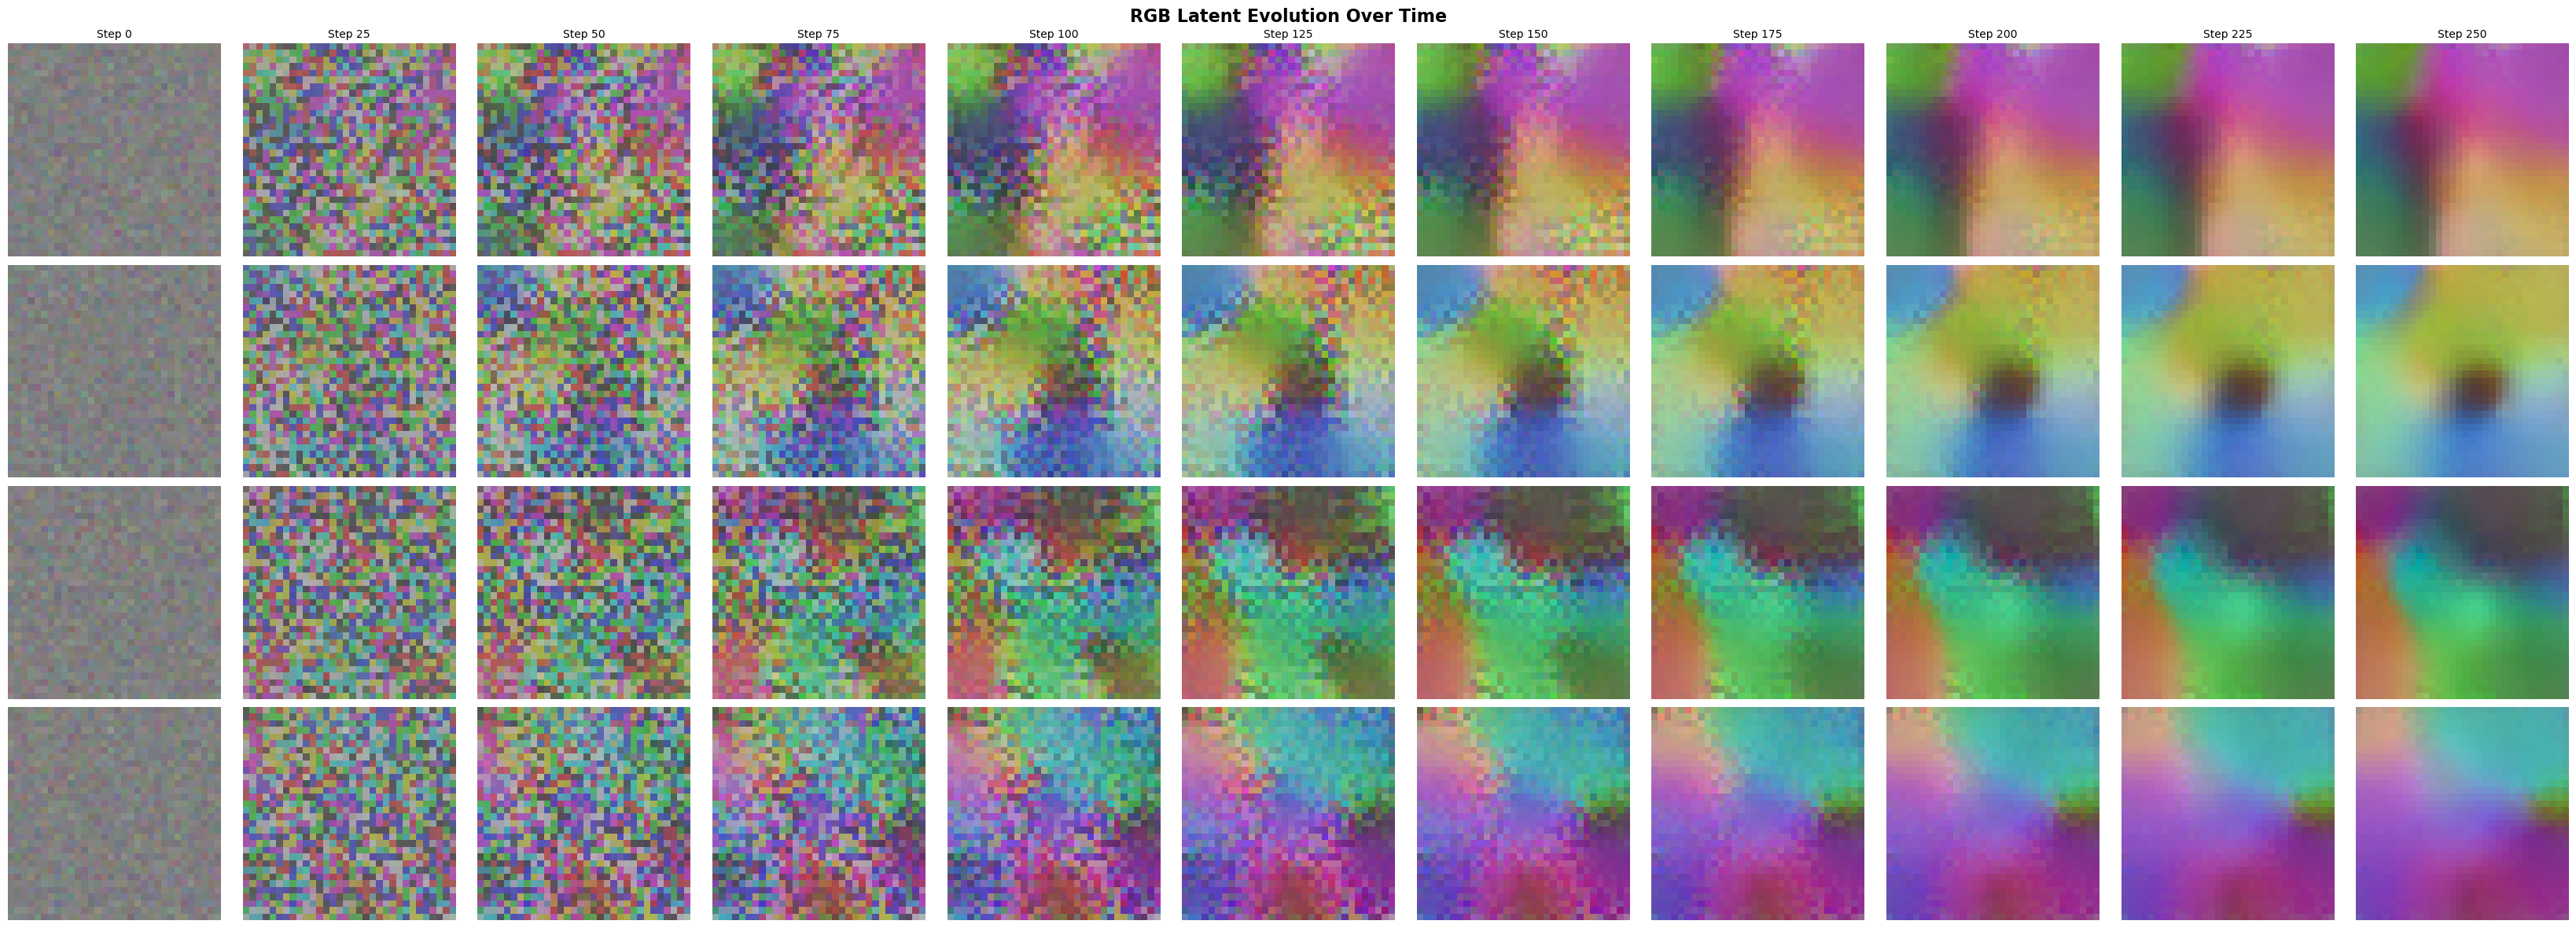


Evolution summary:
  4 latents evolved from step 0 → 250
  Look for diverse spatial patterns across the rows!


In [26]:
# Show evolution of each latent over time
num_snapshots = len(snapshots)

fig, axes = plt.subplots(batch_size, num_snapshots, figsize=(3 * num_snapshots, 3 * batch_size))
if batch_size == 1:
    axes = axes.reshape(1, -1)
if num_snapshots == 1:
    axes = axes.reshape(-1, 1)

for b in range(batch_size):
    for s, (snapshot, step) in enumerate(zip(snapshots, snapshot_steps)):
        ax = axes[b, s]
        rgb = latent_to_rgb(torch.tensor(snapshot[b]))
        ax.imshow(rgb)
        if b == 0:
            ax.set_title(f'Step {step}', fontsize=10)
        if s == 0:
            ax.set_ylabel(f'Latent {b+1}', fontsize=10, rotation=0, labelpad=30)
        ax.axis('off')

plt.suptitle('RGB Latent Evolution Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nEvolution summary:")
print(f"  {batch_size} latents evolved from step {snapshot_steps[0]} → {snapshot_steps[-1]}")
print(f"  Look for diverse spatial patterns across the rows!")

## 5. Side-by-Side Comparison

Initial vs Final for all latents

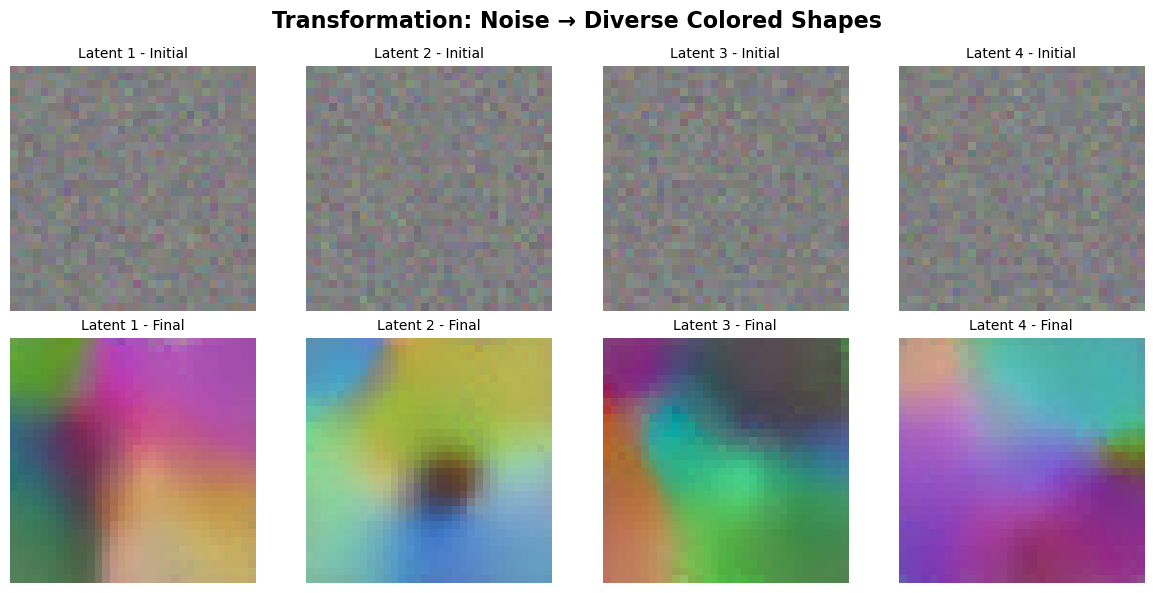


Notice how each latent developed a different spatial pattern!
This is the effect of the spatial diversity loss.


In [27]:
fig, axes = plt.subplots(2, batch_size, figsize=(3 * batch_size, 6))
if batch_size == 1:
    axes = axes.reshape(-1, 1)

# Initial (top row)
for i in range(batch_size):
    rgb = latent_to_rgb(torch.tensor(snapshots[0][i]))
    axes[0, i].imshow(rgb)
    axes[0, i].set_title(f'Latent {i+1} - Initial', fontsize=10)
    axes[0, i].axis('off')

# Final (bottom row)
for i in range(batch_size):
    rgb = latent_to_rgb(torch.tensor(snapshots[-1][i]))
    axes[1, i].imshow(rgb)
    axes[1, i].set_title(f'Latent {i+1} - Final', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Transformation: Noise → Diverse Colored Shapes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNotice how each latent developed a different spatial pattern!")
print("This is the effect of the spatial diversity loss.")

## 6. Plot Loss Curves

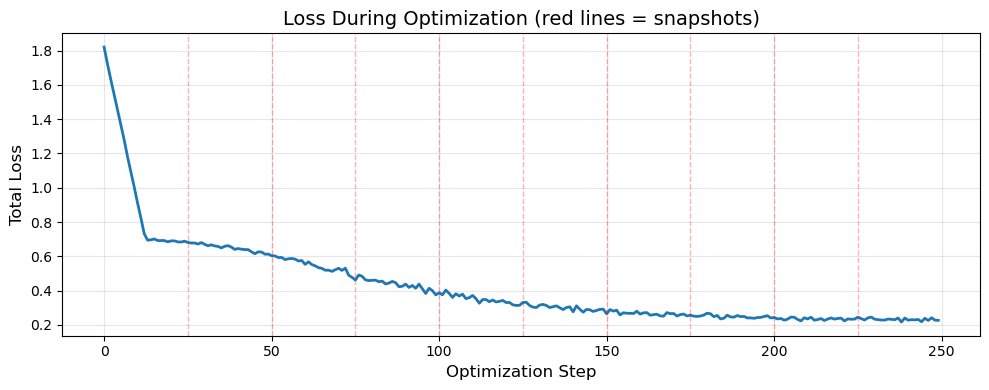

Loss reduction: 87.5%


In [28]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)

# Mark snapshot points
for step in snapshot_steps[1:]:
    if step < len(loss_history):
        plt.axvline(x=step, color='red', alpha=0.3, linestyle='--', linewidth=1)

plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Loss During Optimization (red lines = snapshots)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss reduction: {(loss_history[0] - loss_history[-1]) / abs(loss_history[0]) * 100:.1f}%")

## 7. Compute Spatial Diversity Metric

Measure how different the spatial patterns are over time

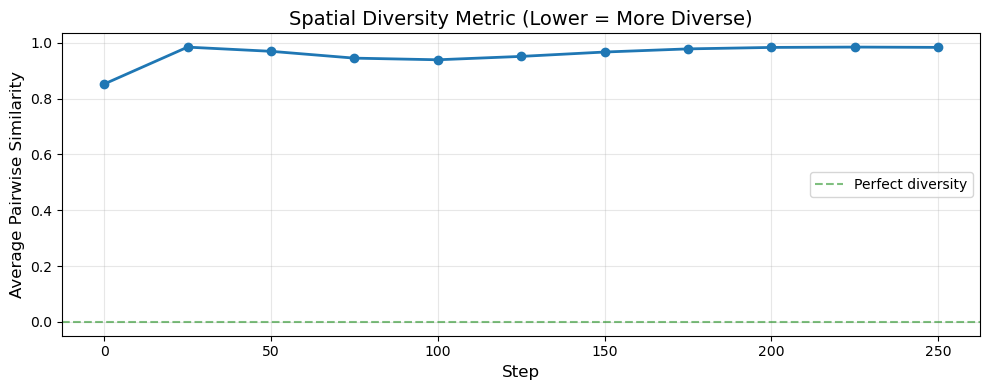

Initial similarity: 0.8523
Final similarity: 0.9837
Change: 0.1314

Lower values = more diverse spatial patterns
Negative values = patterns are pointing in opposite directions!


In [29]:
def compute_pairwise_similarity(latents_bchw):
    """Compute average pairwise spatial similarity for a batch"""
    B = latents_bchw.shape[0]
    if B <= 1:
        return 0.0
    
    # Compute spatial intensity (L2 norm across RGB)
    spatial_intensity = torch.norm(latents_bchw, dim=1)  # [B, H, W]
    spatial_flat = spatial_intensity.reshape(B, -1)  # [B, H*W]
    spatial_norm = F.normalize(spatial_flat, dim=1)
    
    # Pairwise cosine similarity
    similarity = torch.mm(spatial_norm, spatial_norm.t())
    
    # Mask diagonal and average
    mask = torch.eye(B, device=latents_bchw.device, dtype=torch.bool)
    similarity = similarity.masked_fill(mask, 0)
    
    return similarity.sum().item() / (B * (B - 1))

# Compute diversity metric for each snapshot
diversity_scores = []
for snapshot in snapshots:
    snapshot_tensor = torch.tensor(snapshot, dtype=torch.float32)
    score = compute_pairwise_similarity(snapshot_tensor)
    diversity_scores.append(score)

# Plot diversity over time
plt.figure(figsize=(10, 4))
plt.plot(snapshot_steps, diversity_scores, linewidth=2, marker='o', markersize=6)
plt.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Perfect diversity')
plt.xlabel('Step', fontsize=12)
plt.ylabel('Average Pairwise Similarity', fontsize=12)
plt.title('Spatial Diversity Metric (Lower = More Diverse)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial similarity: {diversity_scores[0]:.4f}")
print(f"Final similarity: {diversity_scores[-1]:.4f}")
print(f"Change: {diversity_scores[-1] - diversity_scores[0]:.4f}")
print(f"\nLower values = more diverse spatial patterns")
print(f"Negative values = patterns are pointing in opposite directions!")

## Experiments to Try

Go back to the "Configure Loss Weights and Parameters" cell and try:

### 1. No Cross-Image Diversity (Within-Image Only)
```python
batch_infonce_within_weight = 1.0
batch_infonce_across_weight = 0.0  # DISABLED
```
**Expected**: All latents will likely converge to similar patterns (same blob location)

### 2. Strong Cross-Image Diversity
```python
batch_infonce_across_weight = 2.0  # STRONGER
batch_infonce_temperature_across = 0.1  # Very aggressive
```
**Expected**: Very different spatial patterns (blobs in different locations/shapes)

### 3. Only Cross-Image Diversity (No Within-Image Coherence)
```python
batch_infonce_within_weight = 0.0  # DISABLED
batch_infonce_across_weight = 1.0
```
**Expected**: Diverse patterns but potentially noisy (no smoothness constraint)

### 4. Balanced Approach (Default)
```python
batch_infonce_within_weight = 1.0
batch_infonce_across_weight = 1.0
batch_infonce_temperature_across = 0.5
```
**Expected**: Smooth blobs in different locations

### 5. Vary Batch Size
Try `batch_size = 2` vs `batch_size = 8` to see how many latents affect diversity pressure
(Remember to adjust `batch_infonce_num_cross_images` accordingly)

### 6. Vary Cross-Image Radius
**Exact location matching**:
```python
batch_infonce_cross_image_radius = 0.0
```

**Looser matching**:
```python
batch_infonce_cross_image_radius = 5.0
```

### 7. Adjust Within-Image Coherence Radii
**Tighter coherence** (smaller regions):
```python
batch_infonce_positive_radius = 2.0
batch_infonce_negative_radius = 8.0
```

**Broader coherence** (larger regions):
```python
batch_infonce_positive_radius = 5.0
batch_infonce_negative_radius = 15.0
```